EDA with dataset: [**Past_property_data_EDA**](https://dagshub.com/Omdena/ParisFranceChapter_HousingAffordabilityAnalysis/src/development/src/data/Past_property_data.xlsx)

Analysis:
1.   Analysisng the area and its price for sale property
2.   Analysing the area and its price for rent property
3.   Analyzing the attributes with strong correlations

# Importing the required packages

In [178]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.preprocessing import LabelEncoder

In [179]:
!pip install nltk

# Load Data

In [180]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [181]:
file_path = "/content/drive/MyDrive/Past_property_data_EDA.xlsx"

In [182]:
pd.set_option('display.max_colwidth', 30)

In [183]:
import warnings
warnings.filterwarnings('ignore')

In [184]:
# Load the data from the first sheet
data = pd.read_excel(file_path, sheet_name='Sheet1', dtype={'price': str})
pd.set_option('display.max_colwidth', 30)
# Display the first few rows of the dataframe to understand its structure
data.head(3)


,property_url,title,price,description,rooms_info,amenities_info,legal_info,energy_class,climate_class,subtype,rooms,bedrooms,area,floor,reference,district
0,https://belles-demeures-de...,Apartment sold on 2024-06-...,3250000,"Paris 16th arrondissement,...",1 Living room/dining area...,"Internet, Lift",Seller's commission | « Ca...,D,D,Apartment,8 rooms,4 bedrooms,188.52 m²,6th floor / 7,Reference 84110881,Paris 16th (75016)
1,https://belles-demeures-de...,"Apartment for sale, Paris ...",3500000,Paris 6th District - Jardi...,"1 Double reception room, ...","Internet, Lift, Caretaker,...","3,365,385 € Agency fees no...",D,D,Apartment,8 rooms,5 bedrooms,233 m²,3rd floor / 7,Reference 84420399,Paris 6th (75006)
2,https://belles-demeures-de...,"Apartment for sale, Paris ...",3360000,Paris 7th District – A 3-b...,"1 Double reception room, ...","Internet, Lift, Alarm system",Seller's commission | « Ca...,E,E,Apartment,5 rooms,3 bedrooms,152.23 m²,4th floor / 6,Reference 84485629,Paris 7th (75007)


In [185]:
data.columns #colums in the dataset

Index(['property_url', 'title', 'price', 'description', 'rooms_info',
       'amenities_info', 'legal_info', 'energy_class', 'climate_class',
       'subtype', 'rooms', 'bedrooms', 'area', 'floor', 'reference',
       'district'],
      dtype='object')

Dropping the columns that does add value in EDA

In [186]:
data.drop(columns=['property_url','title','description', 'legal_info', 'reference'], inplace=True)

In [187]:
data.head(1)

,price,rooms_info,amenities_info,energy_class,climate_class,subtype,rooms,bedrooms,area,floor,district
0,3250000,1 Living room/dining area...,"Internet, Lift",D,D,Apartment,8 rooms,4 bedrooms,188.52 m²,6th floor / 7,Paris 16th (75016)


In [188]:
data.isna().sum()

price               0
rooms_info         40
amenities_info     97
energy_class      326
climate_class     337
subtype             0
rooms              27
bedrooms          137
area               22
floor              63
district            0
dtype: int64

# Handling Data for data transformation and cleaning

Extracting the value and adding the column **bathroom_lavatory_counts** from the information given in rooms_info column

In [189]:
def find_bathroom_lavatory_counts(text):
    pattern = r'(\d+)\s*(?:Bathroom(?:s)?|Shower room|(?:Bathroom|Shower room)\s*/\s*Lavatory|Bathroom\s*/\s*Lavator(?:ies|y|y\/ies)|Lavator(?:ies|y|y\/ies))'
    # Find all matches
    matches = re.findall(pattern, text)
    bathroom_lavatory_counts = sum(int(count) for count in matches)
    return bathroom_lavatory_counts

# Apply the function to each row in 'rooms_info'
data['bathroom_lavatory_counts'] = data['rooms_info'].apply(lambda x: find_bathroom_lavatory_counts(x) if pd.notna(x) else np.nan)


In [190]:
pd.set_option('display.max_colwidth', None)
data.loc[60:,['bathroom_lavatory_counts', 'rooms_info']].head(5)

,bathroom_lavatory_counts,rooms_info
60,2.0,"1 Entrance, 1 Living-room, 1 Bedroom, 1 Kitchen, 1 Bathroom, 1 Lavatory"
61,3.0,"1 Entrance 5.11 sq m, 1 Living-room 31.56 sq m, 1 Dining room 11.04 sq m, 1 Kitchen 5.02 sq m, 1 Corridor 10.53 sq m, 1 Lavatory 1.00 sq m, 1 Hallway 4.87 sq m, 1 Lavatory 1.00 sq m, 1 Bedroom 8.59 sq m, 1 Mezzanine 8.40 sq m, 1 Bedroom 9.90 sq m, 1 Bathroom 2.43 sq m, 1 Studio 19.60 sq m"
62,NaN,NaN
63,1.0,"1 Cellar, 1 Entrance 75.00 sq m, 1 Living-room, 1 Principal bedroom, 1 Bathroom / Lavatory, 1 Bedroom, 1 Dining room, 1 Kitchen, 1 Studio 13.04 sq m"
64,1.0,"1 Cellar, 1 Entrance 2.37 sq m, 1 Living room/dining area 23.30 sq m, 1 Kitchen 5.45 sq m, 1 Study 15.20 sq m, 1 Living-room 30.03 sq m, 1 Principal bedroom 21.05 sq m, 1 Bathroom / Lavatory 5.04 sq m, 1 Terrace"


Creating new column is_rent to identify if the property is for rent or sale. Rent price is monthly paid and Sale price is paid once.

In [191]:
pattern = r'month'

# Check if the 'price' column contains the pattern
# mask = df['price'].str.contains(pattern, case=False, na=False)
def check_price_for_rent(text):
  match = re.search(pattern, text, flags=re.IGNORECASE)
  if match:
    return True
  else:
    return False

data['is_rent'] = data['price'].astype(str).apply(lambda x: check_price_for_rent(x) if pd.notna(x) else [])
# Add 'rent' or 'sale' based on the presence of a month
data['rent_or_sale'] = data['is_rent'].apply(lambda x: 'rent' if x else 'sale')
pd.set_option('display.max_colwidth', 30)
# data.head(5)

Cleaning data for price column

In [192]:
def extract_numeric_price(text):
    match = re.search(r'€([\d,]+)', text)
    if match:
        return match.group(1)
    else:
        return text

# Apply the function to the column
data['price'] = data['price'].astype(str).apply(extract_numeric_price)

# Display the updated DataFrame
data[data['rent_or_sale']=="rent"]

,price,rooms_info,amenities_info,energy_class,climate_class,subtype,rooms,bedrooms,area,floor,district,bathroom_lavatory_counts,is_rent,rent_or_sale
87,"2,146",NaN,NaN,NaN,NaN,Apartment,2 rooms,NaN,50 m²,4th,Paris 4th (75004),NaN,True,rent
88,"8,865",1 Living room/dining area...,"Air-conditioning, Double g...",E,C,Apartment,3 rooms,2 bedrooms,106 m²,6th floor / 6,Paris 16th (75016),3.0,True,rent
89,"1,860","1 Entrance, 1 Living roo...","Lift, Double glazing, Digi...",F,C,Apartment,2 rooms,1 bedroom,50 m²,4th floor / 6,Paris 3rd (75003),1.0,True,rent
90,"1,850","1 Entrance 0.71 sq m, 1 ...","Double glazing, Optical fi...",D,B,Apartment,2 rooms,1 bedroom,47.63 m²,2nd,Paris 16th (75016),1.0,True,rent
91,"1,800","1 Entrance, 1 Living roo...","Double glazing, Furnished,...",D,E,Apartment,2 rooms,1 bedroom,46.3 m²,3rd,Paris 17th (75017),2.0,True,rent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1940,"3,330","1 Living-room 50.15 sq m,...","Double glazing, Lift, Digi...",E,G,Apartment,4 rooms,2 bedrooms,134.21 m²,30th floor / 2,Paris 13th (75013),4.0,True,rent
1941,"25,117","1 Entrance, 1 Double rec...","Fireplace, Double glazing,...",G,G,Apartment,10 rooms,3 bedrooms,632 m²,1st,Paris 7th (75007),4.0,True,rent
1942,"4,582","1 Living-room, 1 Dining ...","Lift, Intercom, Fireplace,...",D,E,Apartment,6 rooms,3 bedrooms,126 m²,5th floor / 6,Paris 7th (75007),2.0,True,rent
1946,"4,900","3 Bedrooms, 2 Lavatories...","Lift, Caretaker, Intercom,...",NaN,NaN,Apartment,5 rooms,3 bedrooms,122 m²(total : 150 m²),7th floor / 7,Paris 17th (75017),4.0,True,rent


In [193]:
data[data['price']=="Price on request"].shape

(64, 14)

In [194]:
data = data[data['price']!="Price on request"]
data['price'] = data['price'].str.replace(',', '').astype(int)
# Convert 'price' column to numeric, setting errors='coerce' to handle 'Price on request'
data['price'] = pd.to_numeric(data['price'], errors='coerce')

# Calculate the mean price per district
mean_price_per_district = data.groupby('district')['price'].mean()

# Fill missing values with the mean price of the respective district
data['price'] = data.apply(
    lambda row: mean_price_per_district[row['district']] if np.isnan(row['price']) else row['price'],
    axis=1
)


In [195]:
data.groupby('rent_or_sale').count()

,price,rooms_info,amenities_info,energy_class,climate_class,subtype,rooms,bedrooms,area,floor,district,bathroom_lavatory_counts,is_rent
rent_or_sale,,,,,,,,,,,,,
rent,1788,1780,1758,1631,1625,1788,1781,1718,1783,1768,1788,1780,1788
sale,1675,1650,1617,1515,1510,1675,1656,1615,1661,1636,1675,1650,1675


Cleaning data for floor column


*   Extracting the floor value from the column since is it mixture of floor number and its text details.
*  Below is the word cloud to view the vales in floor column that does have any numeric value.



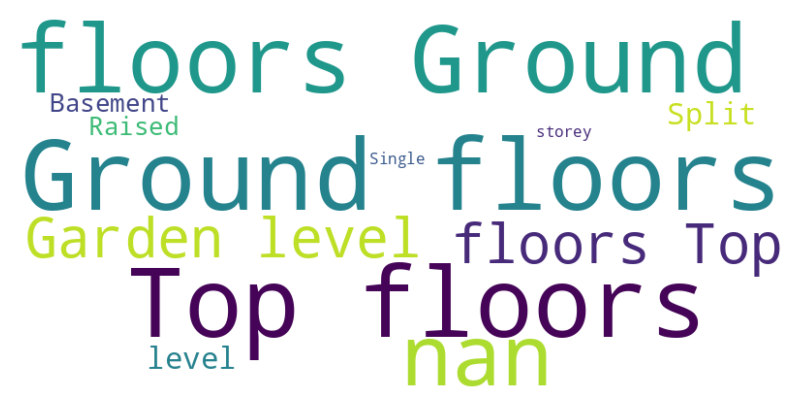

In [196]:
def preprocess_text(text):
    text = re.sub(r'\b\d+\b', '', text)  # Remove standalone numbers
    text = re.sub(r'\b\d+\s*\w*\b', '', text)  # Remove numbers with optional following words
    text = re.sub(r'\bfloor\b', '', text, flags=re.IGNORECASE)  # Remove 'floor'
    return text

# Apply preprocessing to each description
data['floor']=data['floor'].astype(str)
data['floor_preprocessed'] = data['floor'].apply(lambda x: preprocess_text(x) if pd.notna(x) else [])

# Concatenate all processed descriptions into a single text
all_text = ' '.join(data['floor_preprocessed'])


# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the Word Cloud

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [197]:
def frequency_count(all_text):
  # Split the text into words
  words = all_text.split()

  # Count the frequency of each word
  word_counts = Counter(words)

  # Convert to DataFrame for easy plotting
  word_counts_df = pd.DataFrame(list(word_counts.items()), columns=['Word', 'Frequency'])

  # Sort by frequency in descending order
  word_counts_df = word_counts_df.sort_values(by='Frequency', ascending=False)

  # Plot the top 20 words by frequency
  plt.figure(figsize=(10, 6))
  plt.bar(word_counts_df['Word'].head(20), word_counts_df['Frequency'].head(20))
  plt.xlabel('Words')
  plt.ylabel('Frequency')
  plt.title('Top 20 Words by Frequency')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()

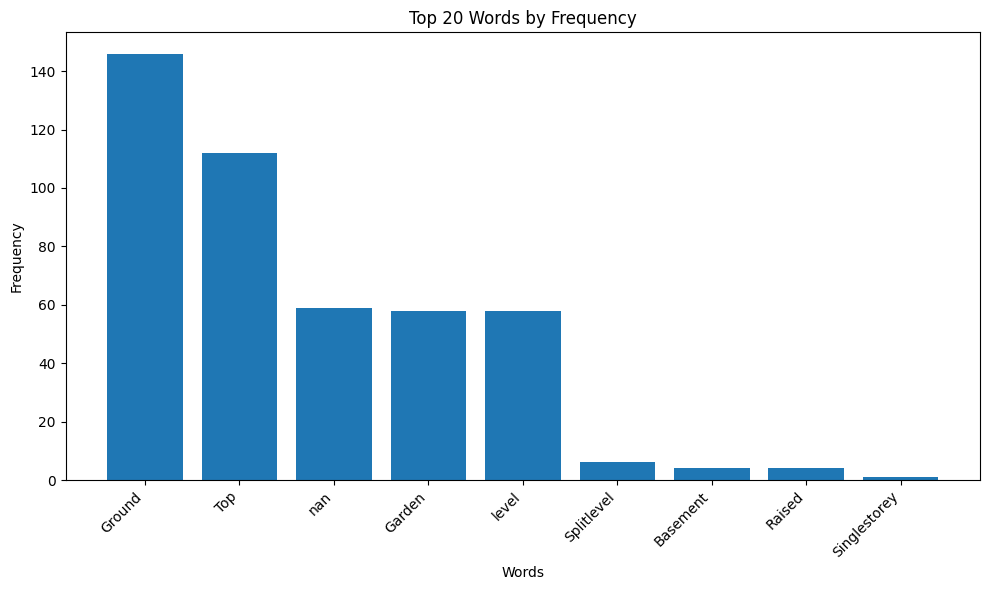

In [198]:
pattern = r'/|floors|-'
# Remove '/' using re.sub()
clean_text = re.sub(pattern, '', all_text)
frequency_count(clean_text)

In [199]:
data.isnull().sum()

price                         0
rooms_info                   33
amenities_info               88
energy_class                317
climate_class               328
subtype                       0
rooms                        26
bedrooms                    130
area                         19
floor                         0
district                      0
bathroom_lavatory_counts     33
is_rent                       0
rent_or_sale                  0
floor_preprocessed            0
dtype: int64

Extracting the numeric value for floor, rooms, and bedrooms columns

In [200]:
# Extract the first numeric value from floor, rooms, and bedrooms
data['floor_num'] = data['floor'].str.extract(r'(\d+)\D*(?=floor|floors)')
data['rooms_num'] = data['rooms'].str.extract(r'(\d+)')
data['bedrooms_num'] = data['bedrooms'].str.extract(r'(\d+)')

# Extract the digit before m2 in the area column
pattern = r'([\d\.]+)\s*m²'
data['area_num'] = data['area'].str.extract(pattern).astype(float)

# Display the updated DataFrame

data[['floor', 'floor_num', 'rooms', 'rooms_num', 'bedrooms', 'bedrooms_num', 'area', 'area_num']].head(10)

,floor,floor_num,rooms,rooms_num,bedrooms,bedrooms_num,area,area_num
0,6th floor / 7,6,8 rooms,8,4 bedrooms,4,188.52 m²,188.52
1,3rd floor / 7,3,8 rooms,8,5 bedrooms,5,233 m²,233.00
2,4th floor / 6,4,5 rooms,5,3 bedrooms,3,152.23 m²,152.23
3,Top floor / 3 floors,3,5 rooms,5,3 bedrooms,3,151.55 m²(total : 144.45 m²),151.55
4,Top floor,NaN,5 rooms,5,3 bedrooms,3,130 m²,130.00
5,4th floor / 6,4,5 rooms,5,2 bedrooms,2,165 m²,165.00
6,nan,NaN,1 room,1,NaN,NaN,NaN,NaN
7,3rd floor / 6,3,5 rooms,5,3 bedrooms,3,203 m²,203.00
8,Garden level,NaN,5 rooms,5,3 bedrooms,3,150 m²(total : 150.62 m²),150.00
9,Top floor,NaN,4 rooms,4,2 bedrooms,2,77 m²(total : 95 m²),77.00


In [201]:
keywords = ['Ground', 'singel-storey', 'garden']
filtered_data = data[data['floor'].str.contains('|'.join(keywords), case=False)]


print("Floor cloumn with values ['Ground', 'singel-storey', 'garden'] is ",filtered_data.shape[0])
# Considering the value as ground for floor values ['Ground', 'singel-storey', 'garden']
data.loc[filtered_data.index,'floor_num'] = 'Ground'

Floor cloumn with values ['Ground', 'singel-storey', 'garden'] is  204


In [202]:
# Extracting the numeric value to filling the missing value for floor with value Top floor (example: Top floor / 3 floor)
filtered_data = data[data['floor'].str.contains('Top', case=False)]

print("Floor cloumn with values Top floor is ",filtered_data.shape[0])

extracted_values = filtered_data['floor'].str.extract(r'(\d+)')
data.loc[filtered_data.index, 'floor_num'] = extracted_values[0].where(extracted_values[0].notna(), 'Top')
data.head(5)

Floor cloumn with values Top floor is  112


,price,rooms_info,amenities_info,energy_class,climate_class,subtype,rooms,bedrooms,area,floor,district,bathroom_lavatory_counts,is_rent,rent_or_sale,floor_preprocessed,floor_num,rooms_num,bedrooms_num,area_num
0,3250000,1 Living room/dining area...,"Internet, Lift",D,D,Apartment,8 rooms,4 bedrooms,188.52 m²,6th floor / 7,Paris 16th (75016),2.0,False,sale,/,6,8,4,188.52
1,3500000,"1 Double reception room, ...","Internet, Lift, Caretaker,...",D,D,Apartment,8 rooms,5 bedrooms,233 m²,3rd floor / 7,Paris 6th (75006),2.0,False,sale,/,3,8,5,233.00
2,3360000,"1 Double reception room, ...","Internet, Lift, Alarm system",E,E,Apartment,5 rooms,3 bedrooms,152.23 m²,4th floor / 6,Paris 7th (75007),2.0,False,sale,/,4,5,3,152.23
3,2400000,"1 Principal bedroom, 1 B...",Lift,C,A,Apartment,5 rooms,3 bedrooms,151.55 m²(total : 144.45 m²),Top floor / 3 floors,Paris 14th (75014),2.0,False,sale,Top / floors,3,5,3,151.55
4,2850000,1 Reception room 50.00 sq...,"Air-conditioning, Double g...",C,C,Apartment,5 rooms,3 bedrooms,130 m²,Top floor,Paris 7th (75007),3.0,False,sale,Top,Top,5,3,130.00


In [203]:
# Handling floor data that has numeric values and no other details like total floor count
def extract_value(description):
    match = re.search(r'\b(\d+)', description)  # Extract numeric value
    if match:
        value = match.group(1) # Extracted numeric value
        if '/' not in description and 'floor' not in description.lower():
            return int(value)  # Convert to integer if conditions are met

filtered_data = data[data['floor_num'].isna()].copy()
filtered_data.loc[:,'floor':'floor_num'].head()
# Apply the function to the 'floor' column in filtered_data
filtered_data['floor_num'] = filtered_data['floor'].apply(extract_value)
filtered_data['floor_num']
# Update 'floor_num' in the original DataFrame using .loc
data.loc[filtered_data.index, 'floor_num'] = filtered_data['floor_num']

In [204]:
data.columns

Index(['price', 'rooms_info', 'amenities_info', 'energy_class',
       'climate_class', 'subtype', 'rooms', 'bedrooms', 'area', 'floor',
       'district', 'bathroom_lavatory_counts', 'is_rent', 'rent_or_sale',
       'floor_preprocessed', 'floor_num', 'rooms_num', 'bedrooms_num',
       'area_num'],
      dtype='object')

In [205]:
data[data['floor_num'].isna()].shape

(68, 19)

In [206]:
floor_missing_data=data.loc[data['floor_num'].isna()]
floor_missing_data.groupby('floor').size()

floor
Basement             1
Raised               2
Raised floor / 3     1
Raised floor / 4     1
Single-storey        1
Split-level          3
nan                 59
dtype: int64

In [207]:
def floor_distribution():
  data['floor_num'].value_counts().plot(kind='bar')
  plt.xlabel('Floor Values')
  plt.ylabel('Frequency')
  plt.title('Floor height of houses')
  plt.show()
# floor_distribution()

In [208]:
# data.drop(index=floor_missing_data.index, inplace=True)

def get_single_mode(series):
    modes = series.mode()
    return modes.iloc[0] if not modes.empty else None

# Calculate the mean floor per district
mode_floor_district = data.groupby('district')['floor_num'].apply(get_single_mode)

def fill_mode(row):
    if pd.isna(row['floor_num']):
        return mode_floor_district[row['district']]
    return row['floor_num']

# Apply the function to fill missing values
data['floor_num'] = data.apply(fill_mode, axis=1)


In [209]:
filtered_index = data.loc[(data['floor_num'] == 'Ground') | (data['floor_num'] == 'Top')].index

# Convert numeric values to integers
data.loc[~data.index.isin(filtered_index), 'floor_num'] = data.loc[~data.index.isin(filtered_index), 'floor_num'].astype(int).astype(str)



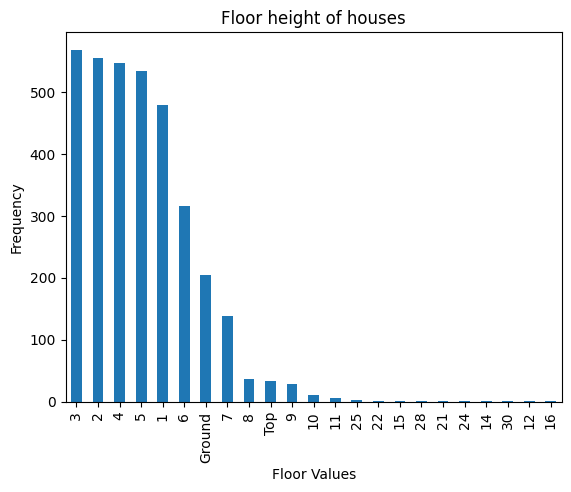

In [210]:
floor_distribution()

In [211]:
data.drop(columns=['floor_preprocessed','area','bedrooms','rooms_info','rooms','amenities_info','floor'], inplace=True)

In [212]:
data.groupby('is_rent').count()

,price,energy_class,climate_class,subtype,district,bathroom_lavatory_counts,rent_or_sale,floor_num,rooms_num,bedrooms_num,area_num
is_rent,,,,,,,,,,,
False,1675,1515,1510,1675,1675,1650,1675,1675,1656,1615,1661
True,1788,1631,1625,1788,1788,1780,1788,1788,1781,1718,1783


In [213]:
data.groupby('subtype').count()

,price,energy_class,climate_class,district,bathroom_lavatory_counts,is_rent,rent_or_sale,floor_num,rooms_num,bedrooms_num,area_num
subtype,,,,,,,,,,,
Apartment,3385,3083,3072,3385,3361,3385,3385,3385,3372,3277,3376
Building,1,1,1,1,1,1,1,1,1,0,1
Business,3,2,2,3,3,3,3,3,3,0,3
Garage/Parking,15,6,6,15,7,15,15,15,2,1,5
House,55,50,50,55,55,55,55,55,55,55,55
Office,4,4,4,4,3,4,4,4,4,0,4


In [214]:
data.isna().sum()

price                         0
energy_class                317
climate_class               328
subtype                       0
district                      0
bathroom_lavatory_counts     33
is_rent                       0
rent_or_sale                  0
floor_num                     0
rooms_num                    26
bedrooms_num                130
area_num                     19
dtype: int64

In [215]:

# List of columns to fill with mode (categorical)
categorical_columns = [
    'energy_class', 'climate_class', 'subtype',
    'district', 'rent_or_sale','floor_num']

# List of columns to fill with median (numerical)
numerical_columns = ['price', 'bathroom_lavatory_counts', 'area_num','rooms_num', 'bedrooms_num']

# Fill categorical columns with mode
for column in categorical_columns:
    mode_value = data[column].mode()[0]  # Get the mode
    data[column].fillna(mode_value, inplace=True)

# Fill numerical columns with median
for column in numerical_columns:
    median_value = data[column].median()  # Get the median
    data[column].fillna(median_value, inplace=True)
data['rooms_num']=data['rooms_num'].astype(int)
data['bedrooms_num']=data['bedrooms_num'].astype(int)
data['bedrooms_num']=data['bathroom_lavatory_counts'].astype(int)


In [216]:
data[data['area_num']>1 ].shape

(3463, 12)

In [217]:
data.isna().sum()

price                       0
energy_class                0
climate_class               0
subtype                     0
district                    0
bathroom_lavatory_counts    0
is_rent                     0
rent_or_sale                0
floor_num                   0
rooms_num                   0
bedrooms_num                0
area_num                    0
dtype: int64

In [218]:
data.describe()

,price,bathroom_lavatory_counts,rooms_num,bedrooms_num,area_num
count,3.463000e+03,3463.000000,3463.000000,3463.000000,3463.000000
mean,9.171870e+05,2.415824,3.907306,2.415824,108.516295
std,1.548978e+06,1.289787,1.787146,1.289787,74.896250
min,2.000000e+02,0.000000,1.000000,0.000000,9.450000
25%,2.995000e+03,2.000000,2.000000,2.000000,57.005000
50%,7.500000e+03,2.000000,4.000000,2.000000,95.000000
75%,1.460000e+06,3.000000,5.000000,3.000000,140.470000
max,2.300000e+07,13.000000,25.000000,13.000000,1837.000000


# Labeling data for categorical columns (Encoding)

In [219]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for column in categorical_columns:
    le = LabelEncoder()
    print(f"Processing column: {column}")
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le  # Store the label encoder for each column

    # Print the mapping of original values to encoded values
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    # print(f"Mapping for {column}:")
    # for original_value, encoded_value in mapping.items():
    #     print(f"  {original_value}: {encoded_value}")


Processing column: energy_class
Processing column: climate_class
Processing column: subtype
Processing column: district
Processing column: rent_or_sale
Processing column: floor_num


In [220]:
data.head(3)

,price,energy_class,climate_class,subtype,district,bathroom_lavatory_counts,is_rent,rent_or_sale,floor_num,rooms_num,bedrooms_num,area_num
0,3250000,3,3,0,7,2.0,False,1,17,8,2,188.52
1,3500000,3,3,0,17,2.0,False,1,13,8,2,233.00
2,3360000,4,4,0,18,2.0,False,1,15,5,2,152.23


In [221]:
data.dtypes

price                         int64
energy_class                  int64
climate_class                 int64
subtype                       int64
district                      int64
bathroom_lavatory_counts    float64
is_rent                        bool
rent_or_sale                  int64
floor_num                     int64
rooms_num                     int64
bedrooms_num                  int64
area_num                    float64
dtype: object

# Analyzing Prices for property type **Rent** and **Sale** in each district

**Rent value is per month and sale value is for property paid at once.**




In [222]:
data_rent_house_monthly = data[data['is_rent'] == True]
data_sale_house= data[data['is_rent'] == False]

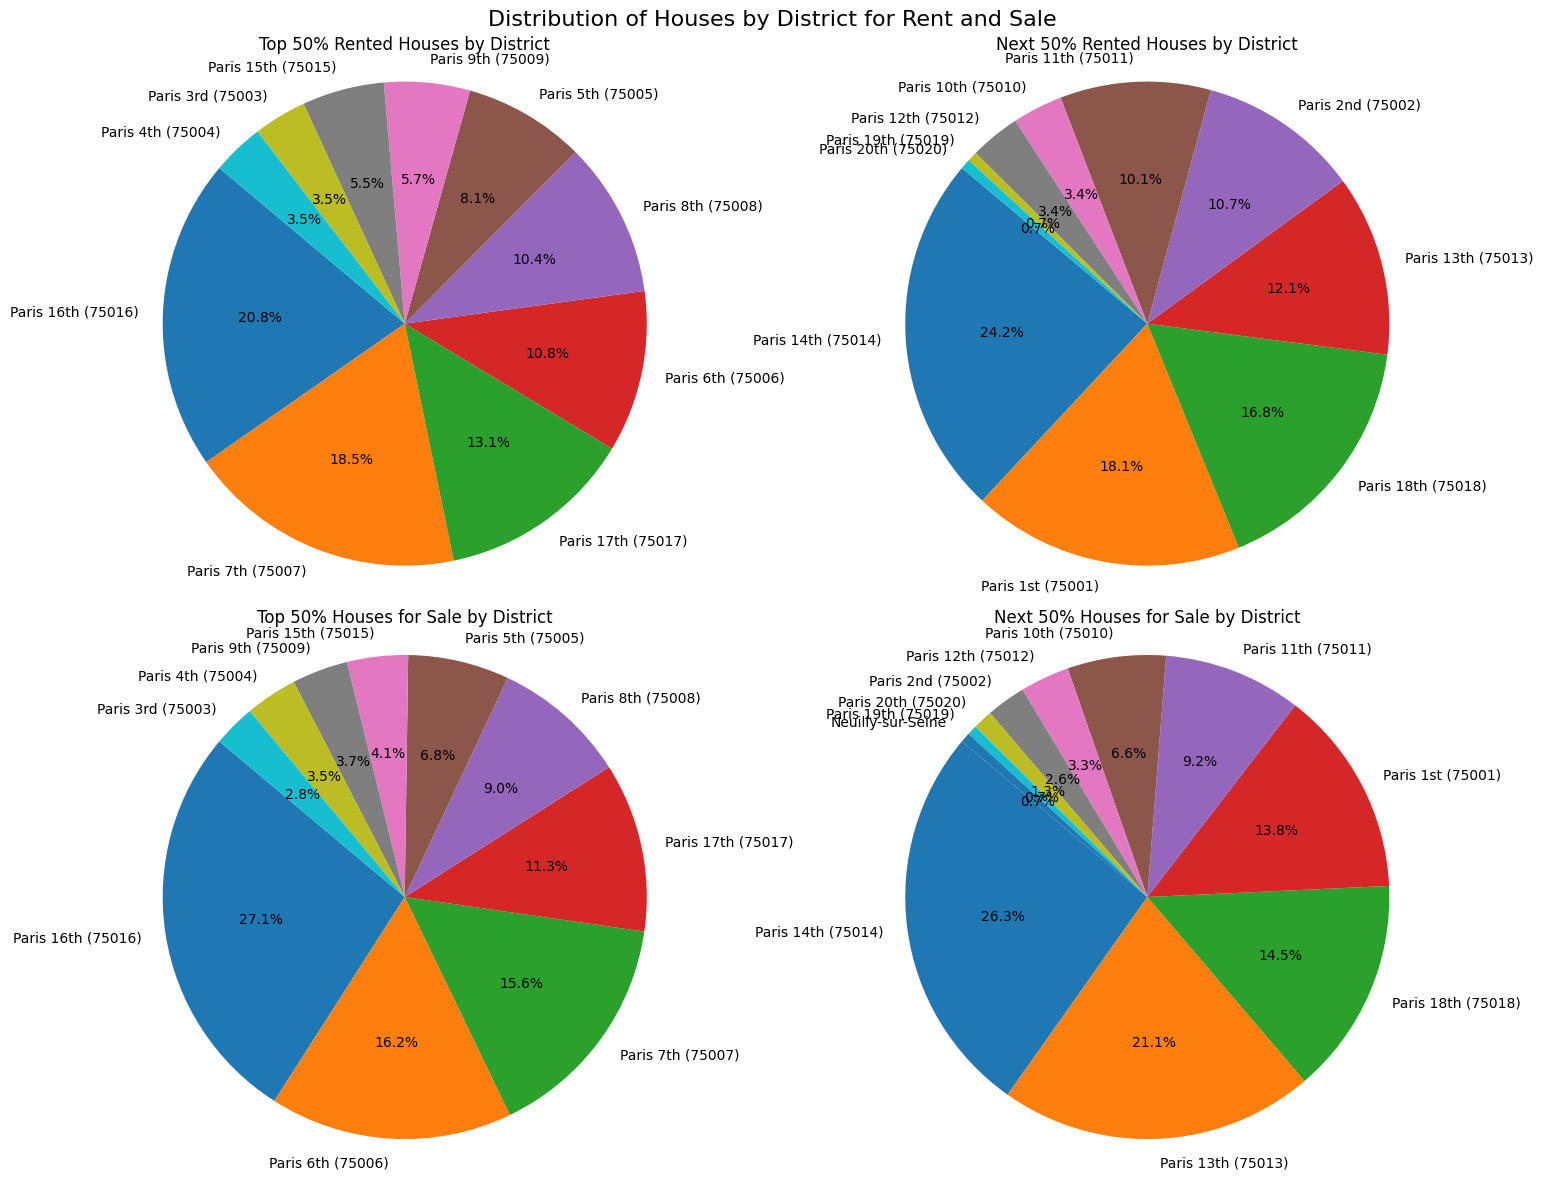

In [223]:
# Count the values of 'district' for each DataFrame
rent_district_counts = data_rent_house_monthly['district'].value_counts()
sale_district_counts = data_sale_house['district'].value_counts()

# Function to split the counts into top 50% and next 50%
def split_counts(counts):
    mid_index = len(counts) // 2
    top_50 = counts[:mid_index]
    next_50 = counts[mid_index:]
    return top_50, next_50

# Split the counts for rented and for-sale houses
rent_top_50, rent_next_50 = split_counts(rent_district_counts)
sale_top_50, sale_next_50 = split_counts(sale_district_counts)

# Assuming 'label_encoders' is a dictionary of LabelEncoders
if 'district' in label_encoders:
    le = label_encoders['district']
    mapping = dict(zip(le.transform(le.classes_), le.classes_))

# Map the encoded values back to district names for each split
rent_top_50_labels = [mapping.get(x, x) for x in rent_top_50.index]
rent_next_50_labels = [mapping.get(x, x) for x in rent_next_50.index]
sale_top_50_labels = [mapping.get(x, x) for x in sale_top_50.index]
sale_next_50_labels = [mapping.get(x, x) for x in sale_next_50.index]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Distribution of Houses by District for Rent and Sale', fontsize=16)
# Pie chart for top 50% rented houses
axs[0, 0].pie(rent_top_50, labels=rent_top_50_labels, autopct='%1.1f%%', startangle=140)
axs[0, 0].set_title('Top 50% Rented Houses by District')
axs[0, 0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Pie chart for next 50% rented houses
axs[0, 1].pie(rent_next_50, labels=rent_next_50_labels, autopct='%1.1f%%', startangle=140)
axs[0, 1].set_title('Next 50% Rented Houses by District')
axs[0, 1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Pie chart for top 50% houses for sale
axs[1, 0].pie(sale_top_50, labels=sale_top_50_labels, autopct='%1.1f%%', startangle=140)
axs[1, 0].set_title('Top 50% Houses for Sale by District')
axs[1, 0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Pie chart for next 50% houses for sale
axs[1, 1].pie(sale_next_50, labels=sale_next_50_labels, autopct='%1.1f%%', startangle=140)
axs[1, 1].set_title('Next 50% Houses for Sale by District')
axs[1, 1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.tight_layout()
plt.show()



In [224]:
def plot_price_vs_district(data, title):
    # Define price bins
    min_price = data['price'].min()
    max_price = data['price'].max()
    bins = np.linspace(min_price, max_price, 15)  # 15 bins
    labels = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)]
    data['price_bin'] = pd.cut(data['price'], bins=bins, labels=labels, include_lowest=True)

    # Compute quartiles
    Q1 = data['price'].quantile(0.25)
    Q2 = data['price'].quantile(0.50)  # Median
    Q3 = data['price'].quantile(0.75)

    # Map categorical districts to numeric values for scatter plot
    data['district_num'] = data['district'].astype('category').cat.codes

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data, x='district_num', y='price_bin', palette='viridis', s=100, legend='full')

    # Add quartile lines
    plt.axhline(y=labels[bins.searchsorted(Q1) - 1], color='r', linestyle='--', label=f'Q1 ({Q1:,.0f})')
    plt.axhline(y=labels[bins.searchsorted(Q2) - 1], color='g', linestyle='--', label=f'Median ({Q2:,.0f})')
    plt.axhline(y=labels[bins.searchsorted(Q3) - 1], color='b', linestyle='--', label=f'Q3 ({Q3:,.0f})')
    plt.axhline(y=labels[bins.searchsorted(Q3) - 1], color='b', linestyle='--', label=f'Q3 ({Q3:,.0f})')

    plt.axhline(y=labels[0], color='orange', linestyle='--', label=f'Min: {min_price:,.0f}')
    plt.axhline(y=labels[-1], color='purple', linestyle='--', label=f'Max: {max_price:,.0f}')

    # Annotate with quartile values
    plt.text(max(data['district_num']), labels[bins.searchsorted(Q1) - 1], f'Q1: {Q1:,.0f}',
             color='r', ha='left', va='center', fontsize=10)
    plt.text(max(data['district_num']), labels[bins.searchsorted(Q2) - 1], f'Median: {Q2:,.0f}',
             color='g', ha='left', va='center', fontsize=10)
    plt.text(max(data['district_num']), labels[bins.searchsorted(Q3) - 1], f'Q3: {Q3:,.0f}',
             color='b', ha='left', va='center', fontsize=10)


    # Customize the plot
    plt.title(title)
    plt.xlabel('District')
    plt.ylabel('Price Range in euros')
    plt.xticks(rotation=45)
    if 'district' in label_encoders:
        le = label_encoders['district']
        mapping = dict(zip(le.transform(le.classes_), le.classes_))
        plt.xticks(ticks=range(len(mapping)), labels=[mapping.get(x, x) for x in range(len(mapping))])

    # Add legend
    plt.legend(title='Quartiles', loc='upper right')

    # Show plot
    plt.tight_layout()
    plt.show()


**From above chart we can imply that Paris 16th, Paris 17th, Paris 7th and Paris 6th, Paris 8th and Paris 5 has more property to rent or sale. People should find more options in this district if they want to find the property.**

# Countplot to check the frequent values for the columns

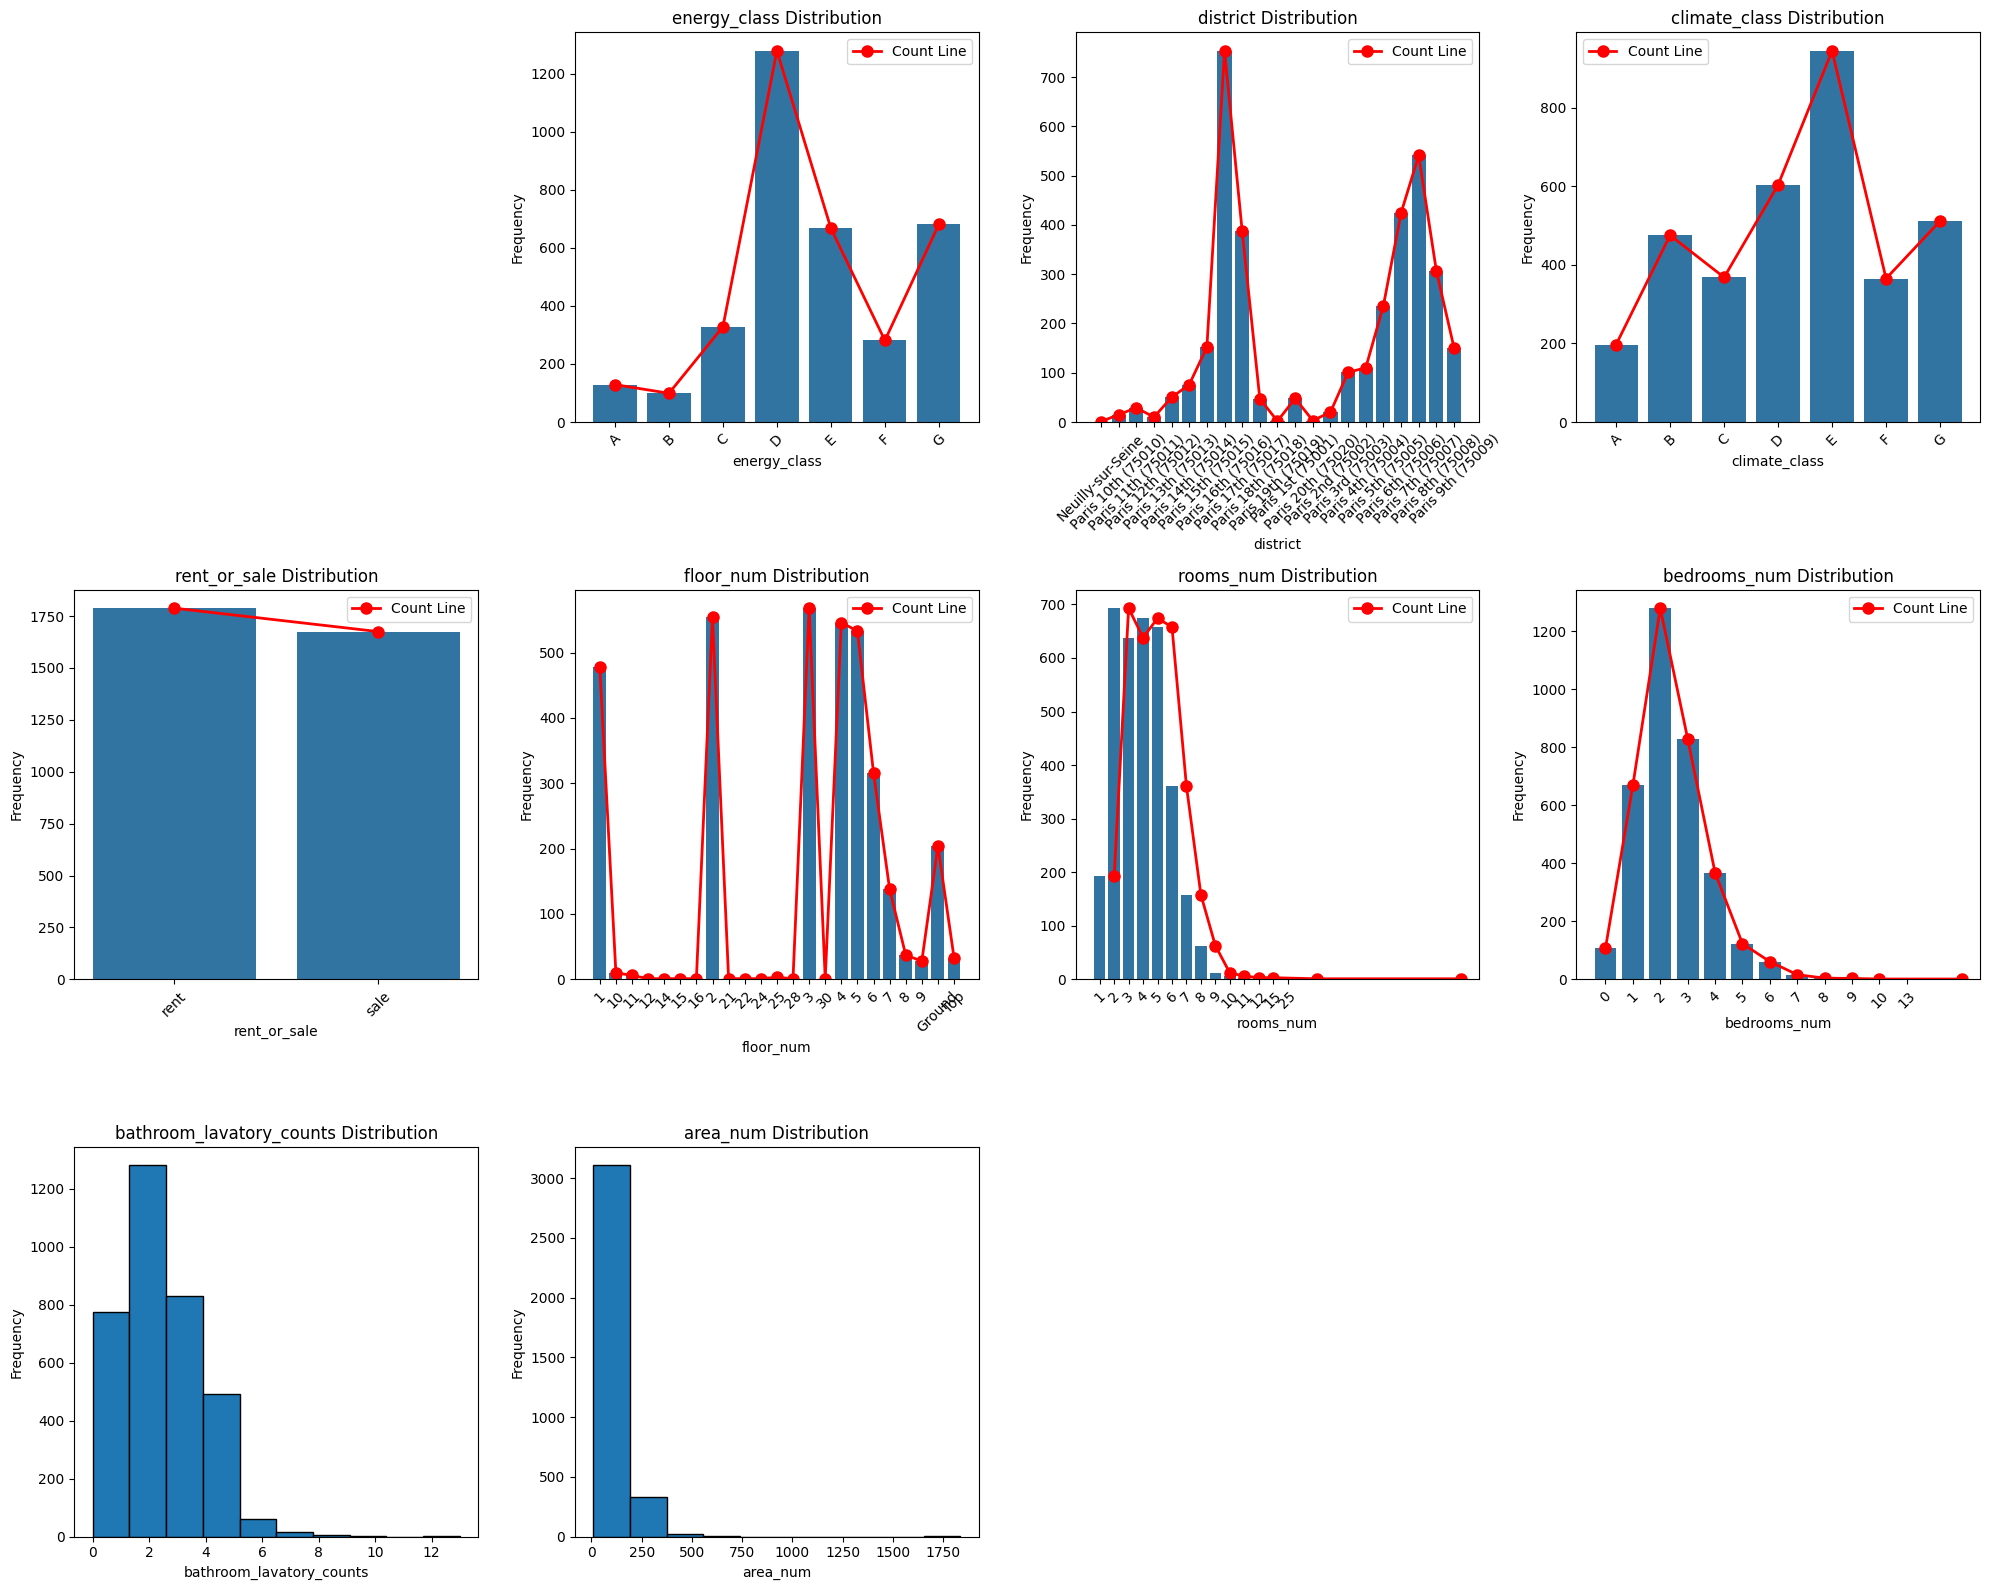

In [225]:
def plot_frequency_distributions(data):
    plt.figure(figsize=(20, 16))

    # Plot Bar Charts for categorical variables
    categorical_cols = ['energy_class', 'district', 'climate_class','rent_or_sale', 'floor_num', 'rooms_num', 'bedrooms_num']

    for i, col in enumerate(categorical_cols):
        plt.subplot(3,4,i+2)
        sns.countplot(data=data, x=col)
        plt.title(f'{col} Distribution')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
                # Map encoded x-axis values to original values
        if col in label_encoders:
            le = label_encoders[col]
            mapping = dict(zip(le.transform(le.classes_), le.classes_))
            plt.xticks(ticks=range(len(mapping)), labels=[mapping.get(x, x) for x in range(len(mapping))])
                # Draw a line over the count distribution
        # Get the counts and categories
        counts = data[col].value_counts().sort_index()
        categories = counts.index

        # Overlay line plot
        plt.plot(categories, counts, color='r', linestyle='-', marker='o', linewidth=2, markersize=8, label='Count Line')
        plt.legend()

    # Plot Histogram for float columns
    float_cols = ['bathroom_lavatory_counts', 'area_num']
    for i, col in enumerate(float_cols):
        plt.subplot(3, 4, len(categorical_cols) + i + 2)
        plt.hist(data[col], bins=10, edgecolor='black')
        plt.title(f'{col} Distribution')
        plt.xlabel(col)
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Plot frequency distributions
plot_frequency_distributions(data)

# Visualizing data for outliers

In [226]:
def plot_boxplot_with_quartiles(data, column):
    plt.figure(figsize=(10, 6))

    # Create the boxplot
    ax = sns.boxplot(x=data[column])
    # Set plot title and labels
    plt.title('Boxplot of Area with Quartile Lines')
    plt.xlabel('Area in square meters')
    plt.ylabel('Frequency')

    plt.show()

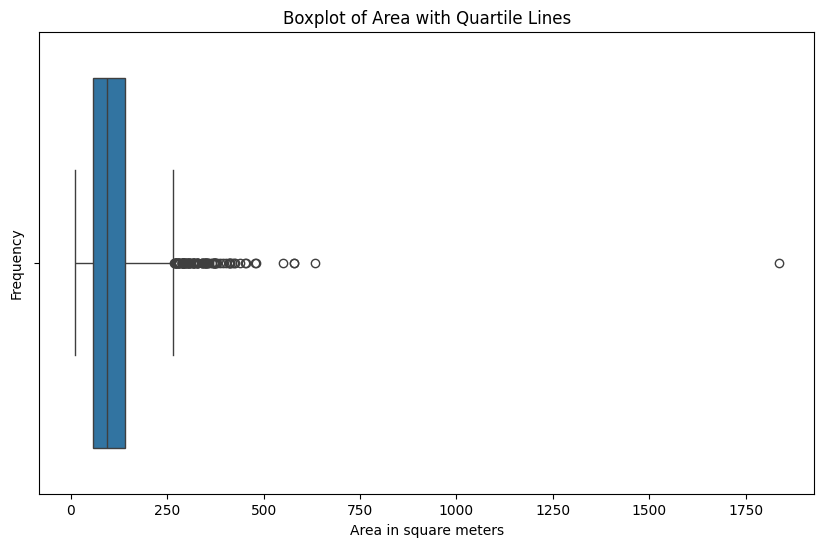

In [227]:
plot_boxplot_with_quartiles(data, 'area_num')

In [228]:

def plot_histogram_for_price(data, title):
    plt.figure(figsize=(10, 6))
    min_price = data['price'].min()
    max_price = data['price'].max()
    bins = np.linspace(min_price, max_price, 15)  # 15 bins
    labels = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)]
    data['price_bin'] = pd.cut(data['price'], bins=bins, labels=labels, include_lowest=True)
    # Create the histogram
    sns.histplot(data['price_bin'], bins=30, kde=False, color='blue')

    # Add labels and title
    plt.title(title)
    plt.xlabel('Price')
    plt.xticks(rotation=45)
    plt.ylabel('Frequency')

    plt.show()

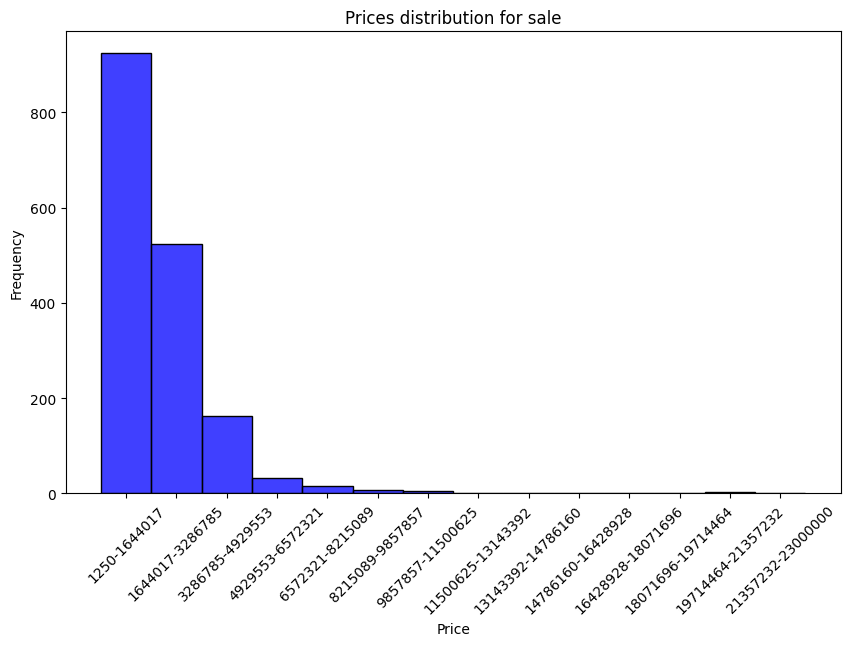

In [229]:
plot_histogram_for_price(data_sale_house, "Prices distribution for sale")

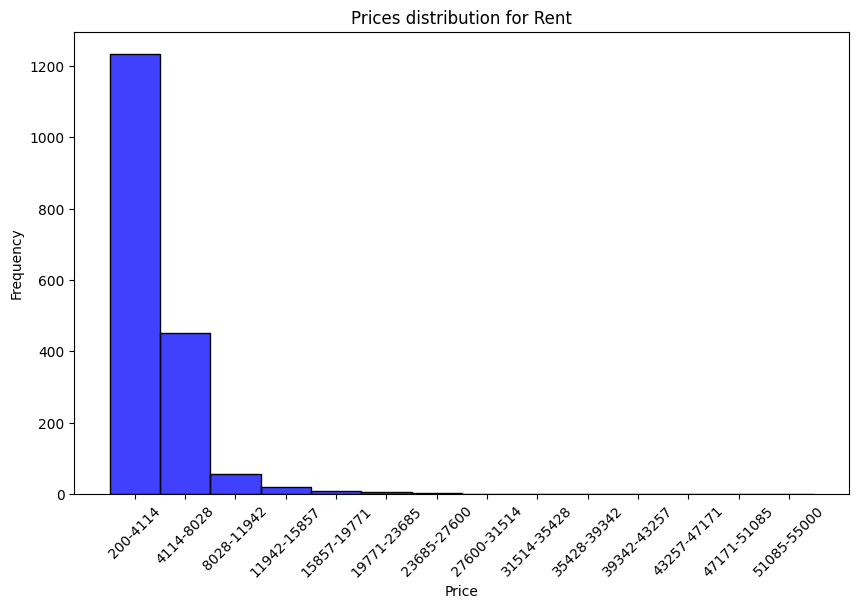

In [230]:
plot_histogram_for_price(data_rent_house_monthly, "Prices distribution for Rent")

In [231]:
min_price = data['price'].min()
max_price = data['price'].max()
bins = np.linspace(min_price, max_price, 15)  # 15 bins
labels = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)]
data['price_bin'] = pd.cut(data['price'], bins=bins, labels=labels, include_lowest=True)


In [232]:
#Checking price bins and property count
data['price_bin'].value_counts()

price_bin
200-1643042          2712
1643042-3285885       523
3285885-4928728       163
4928728-6571571        32
6571571-8214414        15
8214414-9857257         7
9857257-11500100        6
19714314-21357157       2
13142942-14785785       1
14785785-16428628       1
21357157-23000000       1
11500100-13142942       0
16428628-18071471       0
18071471-19714314       0
Name: count, dtype: int64

In [233]:
data.drop(columns=['price_bin'], inplace=True)

# Handling Outlier for columns price and area based on the chart above

In [234]:
#Handling outlier for area column
from scipy import stats
def remove_outliers(data, column):
  data['zscore'] = np.abs(stats.zscore(data['area_num']))

  # Set the threshold
  threshold = 3

  # Filter out the outliers
  df_no_outliers = data[data['zscore'] < threshold]

  # Drop the Z-score column if it's no longer needed
  df_no_outliers = df_no_outliers.drop(columns=['zscore'])
  print(data.shape[0]-df_no_outliers.shape[0])
  return df_no_outliers
df_no_outliers= remove_outliers(data, 'area_num')

46


In [235]:
data_rent_house_monthly = data[data['is_rent'] == True]
data_sale_house= data[data['is_rent'] == False]

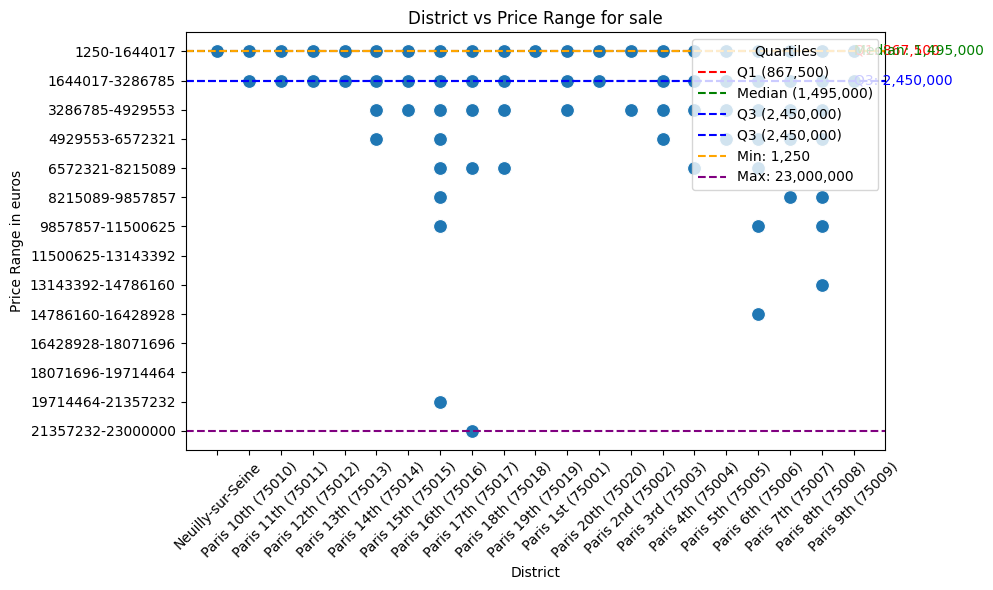

In [236]:
plot_price_vs_district(data_sale_house, 'District vs Price Range for sale')

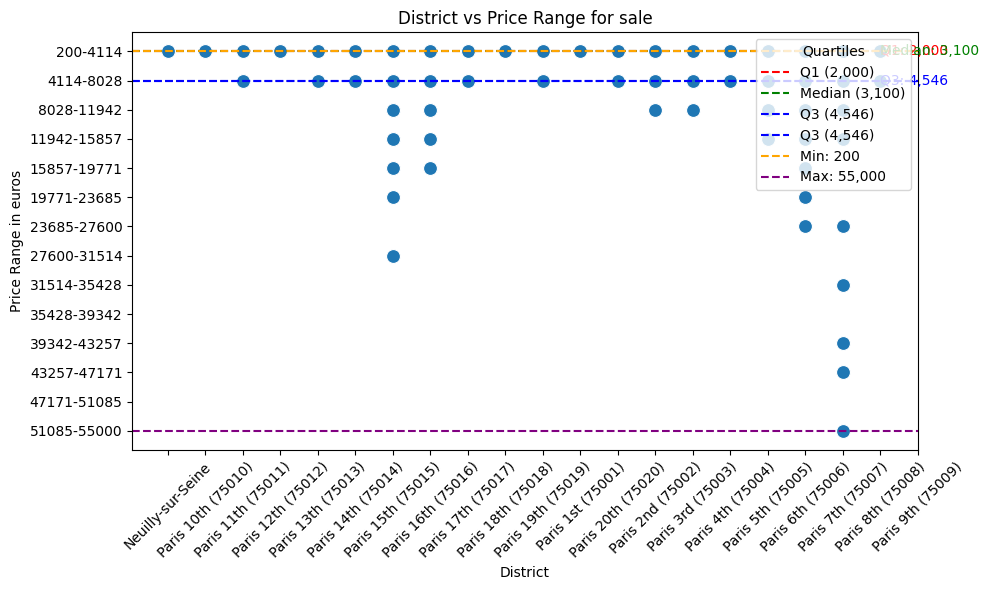

In [237]:
plot_price_vs_district(data_rent_house_monthly, 'District vs Price Range for sale')

In [238]:
# Calculate the IQR for outlier removal for price column
Q1 = df_no_outliers['price'].quantile(0.25)
Q3 = df_no_outliers['price'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outlier removal
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_no_outliers = df_no_outliers[(df_no_outliers['price'] >= lower_bound) & (df_no_outliers['price'] <= upper_bound)]

# Visulatizing prices of Sale and Rent property for each district

In [239]:
data_rent_house_monthly = df_no_outliers[df_no_outliers['is_rent'] == True]
data_sale_house= df_no_outliers[df_no_outliers['is_rent'] == False]

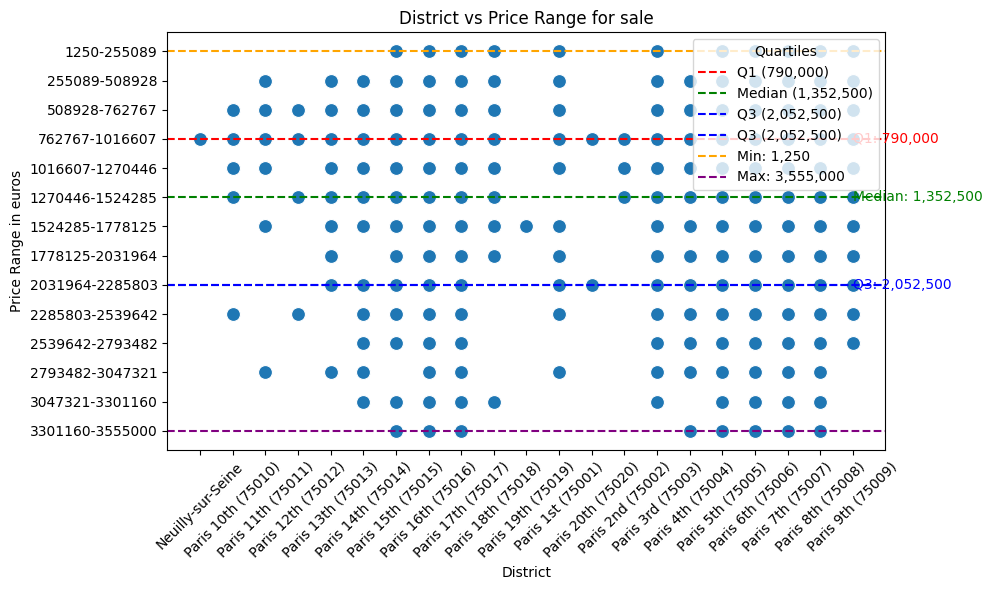

In [240]:
plot_price_vs_district(data_sale_house, 'District vs Price Range for sale')

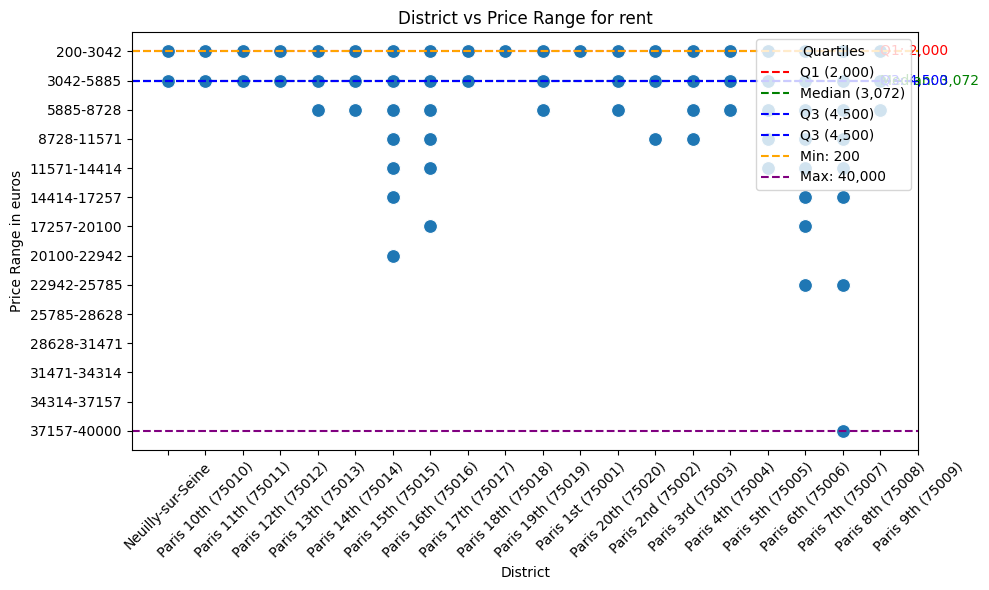

In [241]:
plot_price_vs_district(data_rent_house_monthly, 'District vs Price Range for rent')

# Correlation matrix for Rent Property




In [242]:
# Separate data into two subsets based on is_rent
data_rent_house_monthly = df_no_outliers[df_no_outliers['is_rent'] == True]
data_sale_house= df_no_outliers[df_no_outliers['is_rent'] == False]
data_rent_true = data_rent_house_monthly.drop(columns=['is_rent', 'rent_or_sale'])
data_rent_false = data_sale_house.drop(columns=['is_rent', 'rent_or_sale'])

# Calculate correlation matrices
correlation_rent_true = data_rent_true.corr()
correlation_rent_false = data_rent_false.corr()



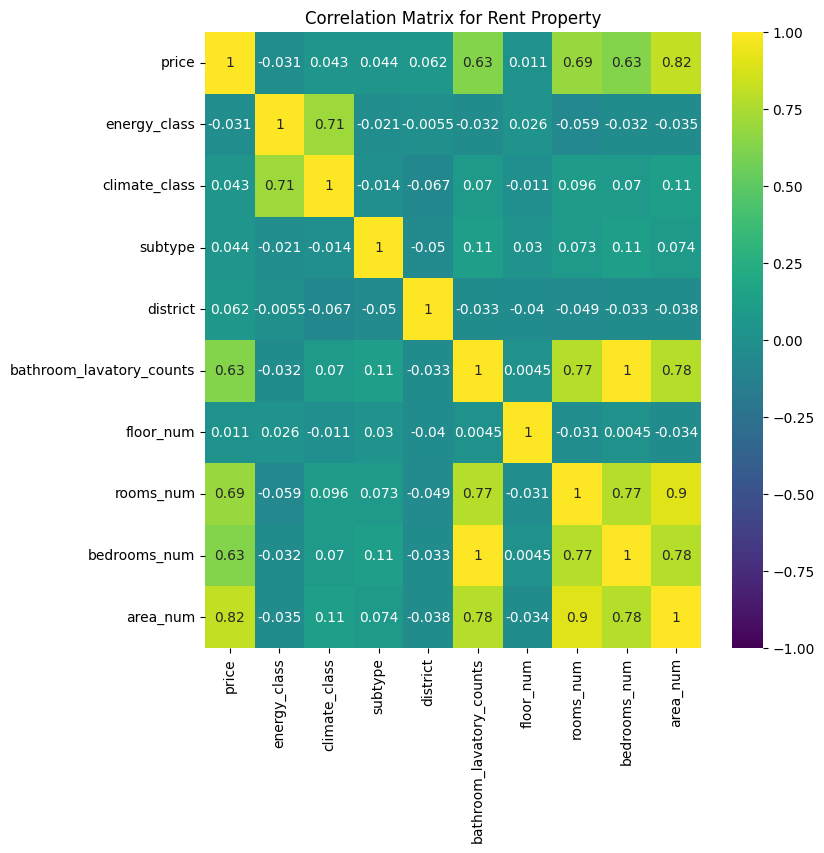

In [243]:
# Plot correlation heatmaps for Rent
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_rent_true, annot=True, cmap='viridis', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Rent Property')
plt.show()

# Correlation matrix for Sale property

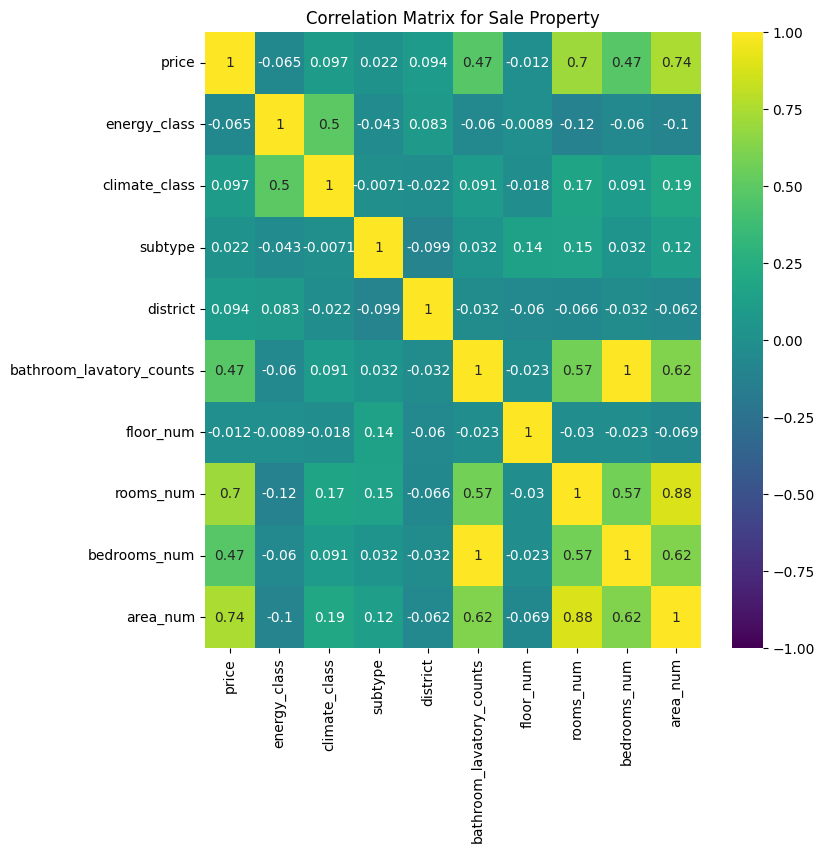

In [244]:
# Plot correlation heatmaps for Rent
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_rent_false, annot=True, cmap='viridis', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Sale Property')
plt.show()

# Analysing the average area of house with the price for sale and rent

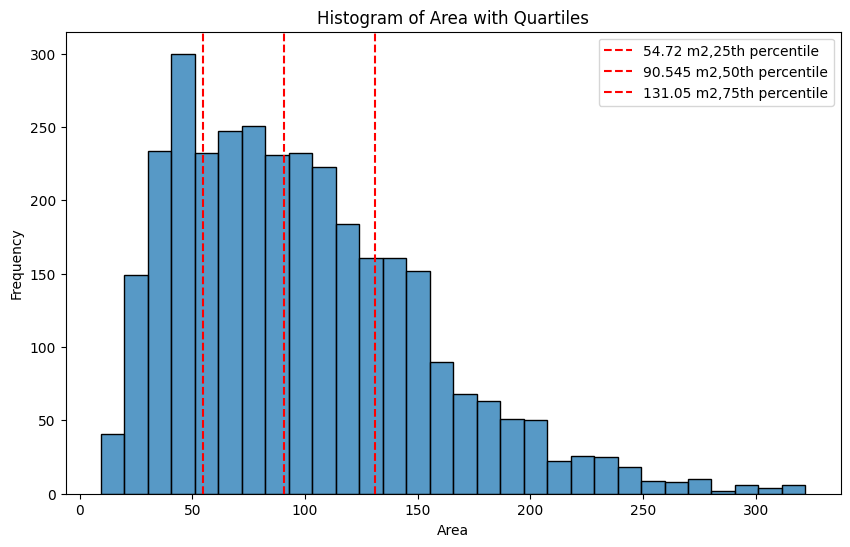

In [245]:

quartiles = np.percentile(df_no_outliers['area_num'], [25, 50, 75])
# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_no_outliers['area_num'], bins=30, kde=False)

# Add quartile lines
for q, percentile in zip(quartiles, [25, 50, 75]):
    plt.axvline(x=q, color='r', linestyle='--', label=f'{q} m2,{percentile}th percentile')

# Add labels and title
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.title('Histogram of Area with Quartiles')
plt.legend()

# Show plot
plt.show()



In [246]:
def area_price(data, title):
  area_quantiles = data['area_num'].quantile([0.25, 0.5, 0.75])
  summary_data = []

  # Print the price for each quantile
  for quantile, area in area_quantiles.items():
      price_at_quantile = data.loc[data['area_num'] >= area, 'price']
      if not filtered_data.empty:
            estimated_price = price_at_quantile.mean().round(2)
            summary_data.append((f"≥ {area:.2f} m²", estimated_price))
            print(f"Price for area_num at quantile {quantile} (area_num = {area}): {estimated_price}")

  # Create a DataFrame for the summary data
  summary_df = pd.DataFrame(summary_data, columns=['Area', 'Mean Price'])

  # Plot the data
  plt.figure(figsize=(10, 6))
  plt.bar(summary_df['Area'], summary_df['Mean Price'], color=['blue', 'green', 'red'])
  plt.xlabel('Area (m²)')
  plt.ylabel('Mean Price (€)')
  plt.title(f'Mean Price for {title} Property for Different Area Ranges')
  plt.xticks(rotation=45)
  plt.show()


Price for area_num at quantile 0.25 (area_num = 51.0): 4346.88
Price for area_num at quantile 0.5 (area_num = 84.47): 5232.41
Price for area_num at quantile 0.75 (area_num = 128.2): 6625.0


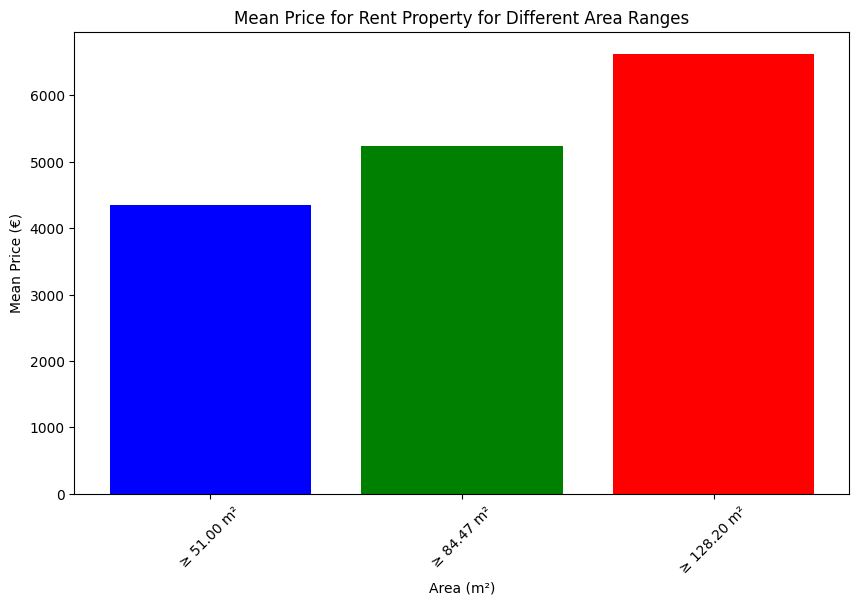

In [247]:
area_price(data_rent_house_monthly, "Rent")


Price for area_num at quantile 0.25 (area_num = 61.845): 1751051.66
Price for area_num at quantile 0.5 (area_num = 95.345): 2051262.57
Price for area_num at quantile 0.75 (area_num = 134.135): 2373944.84


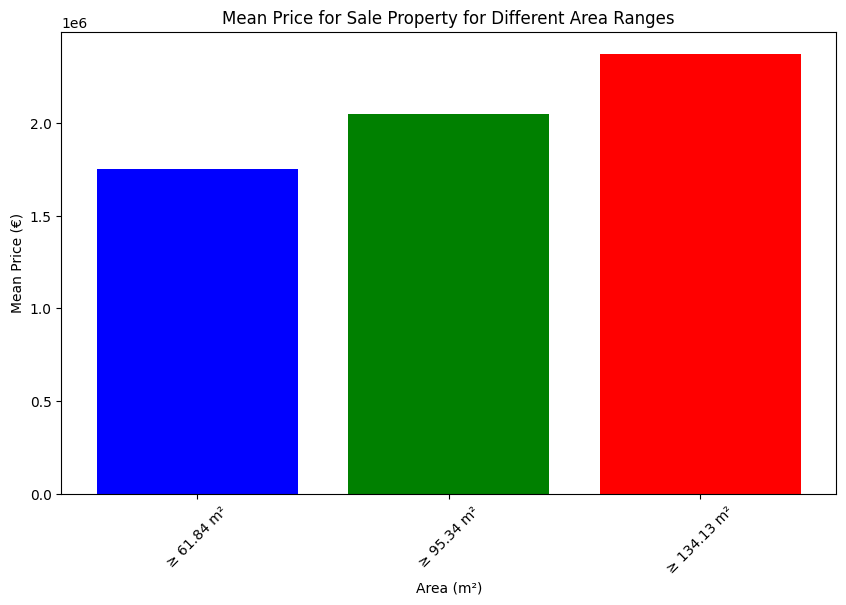

In [248]:
area_price(data_sale_house, "Sale")

**Consolidated Analysis** [Visualize](https://colab.research.google.com/drive/1YNuIyo9YifFPhl594KeSLR17asRBPtLM#scrollTo=jsBp3sd-fHZK&line=4&uniqifier=1)


1. **Paris 16th has the highest number of properties listed.** [Visualize](https://colab.research.google.com/drive/1YNuIyo9YifFPhl594KeSLR17asRBPtLM#scrollTo=-KguaVwThkea&line=3&uniqifier=1) The chart shows the poperty distribution by district.
2. **The number of floors in properties ranges from ground level to 6 on average and has property with more floor.**
3. **Most properties feature 2 rooms, with a range of 1 to 6 rooms being common.**
4. **The count of bathrooms and lavatories in properties varies from 1 to 6.**
5. With a value of €1250 being available at some place, **Minimum start range of Properties for sale are priced between €790,000 and €1,352,500 paid in a lump sum.** [visulalize](https://colab.research.google.com/drive/1YNuIyo9YifFPhl594KeSLR17asRBPtLM#scrollTo=31z5o-2HvTEX&line=1&uniqifier=1)
6.  With a value of €200 being available at some place,**Minimum start range of Rental properties are priced between €2000 and €3000 per month.** [visualize](https://colab.research.google.com/drive/1YNuIyo9YifFPhl594KeSLR17asRBPtLM#scrollTo=xhVf64Quu3iv&line=1&uniqifier=1)

7. **The Minimum area of house is from 57 square meter to 140 square meter.** [visualize](https://colab.research.google.com/drive/1YNuIyo9YifFPhl594KeSLR17asRBPtLM#scrollTo=jCTUglW7DgUu&line=1&uniqifier=1)

